# Notebook on How to Use LUS Signal Processing Functions

### Packages

In [56]:
import LUS_processing_functions as lf
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import torch
%matplotlib widget

### Load Data

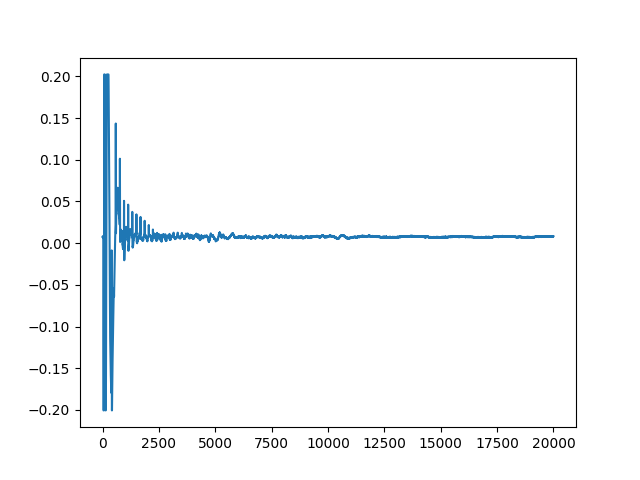

In [ ]:
filename_lookup = "data_example/cutOffs_ZGVs_nu_S1S2_A2A3_S3S6_A4A7.mat" # lamb modes lookup file
filename = "data_example/1100_msg1.mat" # measurement data file
data = sp.io.loadmat(filename)
data = data["data"][0,0][0] # data that contains 2D Array of measurements
plt.figure()
plt.plot(data[0])

### Define Hyperparameters

In [58]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
KL = np.arange(1,20) # Longitudinal modes to consider
KT = 0#np.arange(2,5) # Transversal modes to consider
n0 = 500 # starting sample (throw away transient part)
N = 2500 # len considered signal: n0:n0+N
n0_offset = 32 # transient signal starts after n0_offset samples (important for decay)
ZGV_modes = [True,False,False,False] # which ZGV modes with k!=0 to consider: S1S2, A2A3, psiA4A7, psiS3S6
LUS_estim = lf.LUS_estimator(KL,KT,n0-n0_offset,N,device,filename_lookup,ZGV_modes) # create estimator object

### Initialize Frequencies L and S1S2

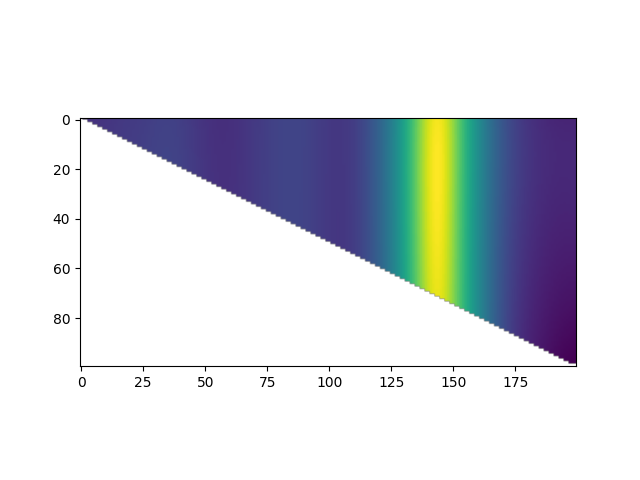

In [59]:
LUS_estim.init_frequencies(data[0,1000:1500],plot=True)

### Highpass filter to suppress transients

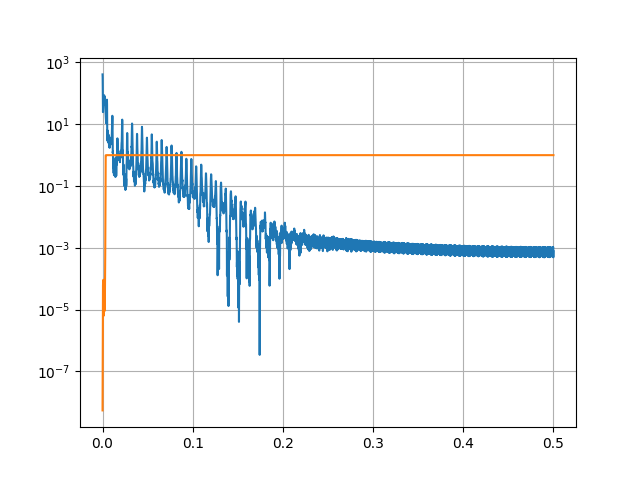

In [60]:
filter_order = 7
max_allowed_ripple_passband_dB = 0.01
min_attenuation_stopband_dB = 40
filter_f_critical = LUS_estim.psiS1S2.cpu().numpy()*0.8
sos = sp.signal.ellip(filter_order,max_allowed_ripple_passband_dB,min_attenuation_stopband_dB, filter_f_critical, 'hp', fs=1, output='sos')
b, a = sp.signal.ellip(filter_order,max_allowed_ripple_passband_dB,min_attenuation_stopband_dB, filter_f_critical, 'hp', fs=1, output='ba')
_, h = sp.signal.freqz(b,a,1000)
plt.figure()
plt.semilogy(np.linspace(0,0.5,2**12),np.abs(np.fft.fft(data[0,500:2500],n=2**13))[:2**12]**2)
plt.semilogy(np.linspace(0,0.5,1000),np.abs(h)**2)
plt.grid()

### Iterative Gauss-Newton fit

In [61]:
iterations_GN = 15
iterations_GN_cov = 10
idx_start = 0
idx_stop = len(data)
step = 10

# parameters of interest
alpha = []
A, B = [], []
psiL = []
psiS1S2 = []

# loop over different measurements
for i in range(idx_start,idx_stop,step):
    dat = torch.tensor(sp.signal.sosfiltfilt(sos,data[i,n0:n0+N]-np.mean(data[i,n0:n0+N])).copy(),device=device)
    for j in range(iterations_GN):
        LUS_estim.step_Gauss_Newton(dat)
    LUS_estim.est_residual_cov_dft(dat,len(dat),p=100)
    for j in range(iterations_GN_cov):
        LUS_estim.step_Gauss_Newton(dat)
    LUS_estim.inv_cov_mat = None
    alpha.append(LUS_estim.get_alpha().cpu().numpy())
    A_temp, B_temp = LUS_estim.est_AB(dat)
    A.append(A_temp.cpu().numpy())
    B.append(B_temp.cpu().numpy())
    psiL.append(LUS_estim.psiL.cpu().numpy().copy())
    psiS1S2.append(LUS_estim.psiS1S2.cpu().numpy().copy())
    print(i)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


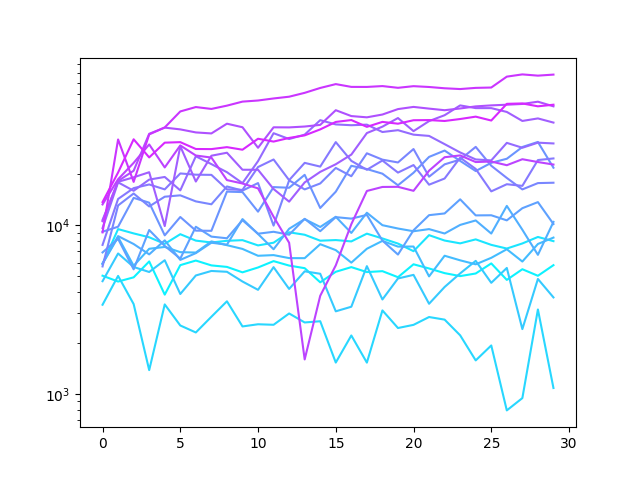

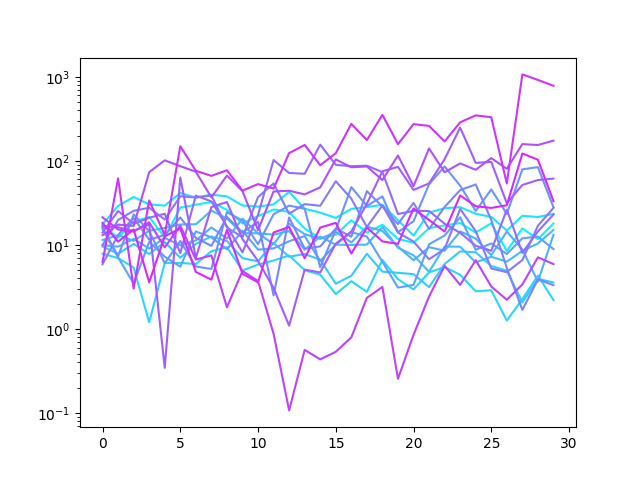

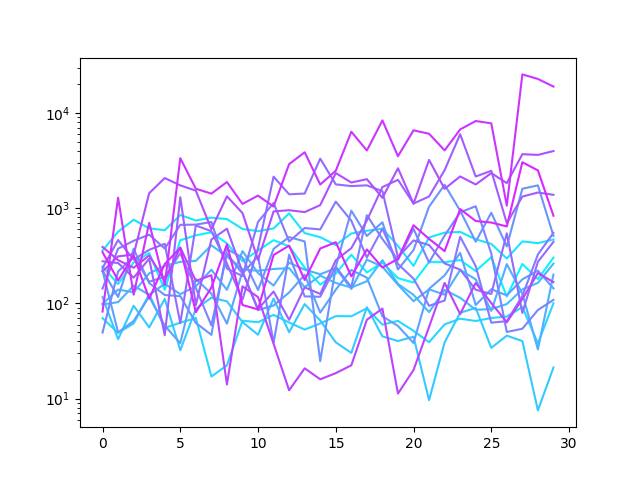

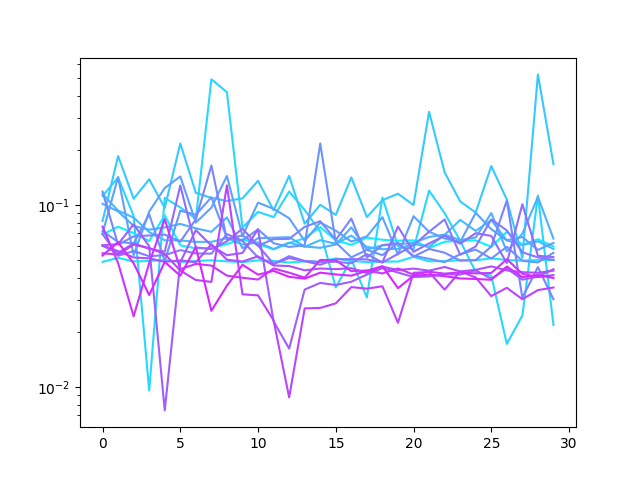

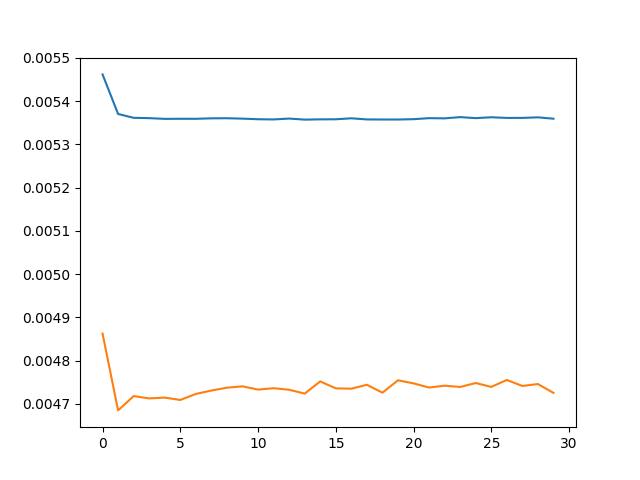

In [62]:
from matplotlib.pyplot import cm
colors = cm.cool(np.linspace(0,1,20))
Ts = 2e-8
plt.figure()
for i in KL[:-3]:
    plt.semilogy([alpha[j][0,i]/Ts for j in range(len(alpha))],c=colors[i])
plt.figure()
for i in KL[:-3]:
    plt.semilogy([A[j][i,0] for j in range(len(A))],c=colors[i])
plt.figure()
for i in KL[:-3]:
    plt.semilogy([B[j][i,0] for j in range(len(B))],c=colors[i])
plt.figure()
for i in KL[:-3]:
    plt.semilogy(np.array([A[j][i,0] for j in range(len(A))])/np.array([B[j][i,0] for j in range(len(B))]),c=colors[i])
plt.figure()
plt.plot([psiL[j] for j in range(len(psiL))])
plt.plot([psiS1S2[j] for j in range(len(psiS1S2))])